In [1]:
%%capture
import torch
major_version, minor_version = torch.cuda.get_device_capability()
# Must install separately since Colab has torch 2.2.1, which breaks packages
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
if major_version >= 8:
    # Use this for new GPUs like Ampere, Hopper GPUs (RTX 30xx, RTX 40xx, A100, H100, L40)
    !pip install --no-deps packaging ninja einops flash-attn xformers trl peft accelerate bitsandbytes
else:
    # Use this for older GPUs (V100, Tesla T4, RTX 20xx)
    !pip install --no-deps xformers trl peft accelerate bitsandbytes
pass

In [2]:
!pip install transformers  # Hugging Face library for NLP model handling
!pip install datasets  # Library for loading and managing datasets

In [3]:
!pip install dotenv

In [4]:
# Import required modules for model management, dataset handling, and fine-tuning
import torch
#from unsloth import FastLanguageModel  # High-performance language model utilities
from unsloth.chat_templates import get_chat_template  # Chat template utility
from datasets import load_dataset  # For loading datasets
from trl import SFTTrainer  # Supervised fine-tuning trainer
from transformers import TrainingArguments  # Configuration for training process
from unsloth.chat_templates import standardize_sharegpt  # Dataset standardization

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


    PyTorch 2.7.0+cu126 with CUDA 1206 (you have 2.6.0+cu124)
    Python  3.11.12 (you have 3.11.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


🦥 Unsloth Zoo will now patch everything to make training faster!


In [5]:
#reloading
from datasets import load_from_disk
train_dataset_new = load_from_disk('./DataPrep/data/dataset_full/train')
validation_dataset_new = load_from_disk('./DataPrep/data/dataset_full/validation')
test_dataset_new = load_from_disk('./DataPrep/data/dataset_full/test')

print(train_dataset_new[0])
print(validation_dataset_new[0])
print(test_dataset_new[0])

{'image_path': './DataPrep/images/img47_seismic.jpg', 'caption': 'This seismic image displays a series of folded sedimentary layers affected by two normal faults, both dipping to the right. The faults offset the anticline and syncline structures, with the rightmost block downthrown relative to the others—indicating extensional deformation superimposed on previously folded strata. A gently dipping angular unconformity truncates the faulted and folded layers at the top, marking a major erosional surface followed by renewed sedimentation. The entire sequence is slightly tilted to the right, suggesting post-depositional tectonic tilting.', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1000x1000 at 0x7F8CDAEC6210>}
{'image_path': './DataPrep/images/img18_seismic.jpg', 'caption': 'This seismic reflection image shows a normal fault dipping to the left, cutting through gently folded sedimentary layers. The left block (hanging wall) is downthrown relative to the right block (foo

In [6]:
instruction = "You are an seismic interpretation expert designed for identifying subsurface geological structures from the seismic images. You will provide a written description for each given image, detailing the specific information displayed in the image."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["caption"]} ]
        },
    ]
    return { "messages" : conversation }

In [7]:
converted_train_dataset = [convert_to_conversation(sample) for sample in train_dataset_new]

converted_train_dataset[0]

converted_eval_dataset = [convert_to_conversation(sample) for sample in validation_dataset_new]

converted_eval_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'You are an seismic interpretation expert designed for identifying subsurface geological structures from the seismic images. You will provide a written description for each given image, detailing the specific information displayed in the image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1000x1000>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'This seismic reflection image shows a normal fault dipping to the left, cutting through gently folded sedimentary layers. The left block (hanging wall) is downthrown relative to the right block (footwall), consistent with extensional tectonics. The presence of pre-existing folds suggests that the area experienced compressional deformation first, followed by normal faulting during later extension — a common sequence in inversion tectonics or rift basin evolution.'}]}]}

In [8]:
!pip install huggingface_hub

In [9]:
import torch
import os

#print(torch.cuda.device_count())
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from unsloth import FastVisionModel
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    #"/mnt/Data/Model/llama-3.2-11B",
    load_in_4bit = True,
    use_gradient_checkpointing = "unsloth",
    device_map="auto",
    token="hf_xxxxx"
)

==((====))==  Unsloth 2025.5.6: Fast Mllama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
import wandb
from dotenv import load_dotenv

load_dotenv()
wb_token = os.getenv("WANBD_TOKEN")

wandb.login(key = wb_token)

#初始化wandb项目
run = wandb.init(
    project = "lora_test",
    job_type= "training",
    anonymous = "allow"
)

wandb: Currently logged in as: charson-hu (fwi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [11]:
model = FastVisionModel.get_peft_model(
    model,
    #target_modules = "",
    finetune_vision_layers     = True,
    finetune_language_layers   = True,
    finetune_attention_modules = True,
    finetune_mlp_modules       = True,

    r = 16, #RANK
    lora_alpha = 16,  #scaling factor
    lora_dropout = 0.1, # Dropout ratio
    bias = "none",   # if training bias
    random_state = 3407,  #seed
    use_rslora = False,
    loftq_config = None,
)

Unsloth: Making `model.base_model.model.vision_model.transformer` require gradients


In [12]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_train_dataset,
    eval_dataset= converted_eval_dataset,
    args = SFTConfig(
        do_train=True,
        do_eval= True,
        per_device_train_batch_size = 4,   #batchsize
        per_device_eval_batch_size= 2,
        gradient_accumulation_steps = 4,   #gradient accumulation steps
        eval_accumulation_steps= 1,
        warmup_steps = 5,   #warmm up
        max_steps = 60,     #max steps
        learning_rate = 2e-4,     #initial learning rate
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 10,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",

        remove_unused_columns = False,
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [13]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 47 | Num Epochs = 20 | Total steps = 60
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 67,174,400/11,000,000,000 (0.61% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,2.363100
20,0.784100
30,0.434400
40,0.178500
50,0.055200
60,0.022100


In [14]:
model.save_pretrained("full_lora_model_test2")
tokenizer.save_pretrained("full_lora_model_test2")

[]

In [20]:
from unsloth import FastVisionModel
from transformers import TextStreamer
model,tokenizer = FastVisionModel.from_pretrained(
    model_name="full_lora_model_test2",
    load_in_4bit = True,
)
FastVisionModel.for_inference(model)


instruction = "You are an seismic interpretation expert designed for identifying subsurface geological structures from the seismic images. You will provide a written description for each given image, detailing the structure information like layer, fold, fault and tilt displayed in the image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]

#
for idx in range(len(test_dataset_new)):
    image = test_dataset_new[idx]["image"]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    print(f"Processing image {idx + 1}/{len(test_dataset_new)}...ing...")
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to("cuda")
    text_streamer = TextStreamer(tokenizer, skip_prompt=True,skip_special_tokens=True)

    generated_tokens = model.generate(
        **inputs,
        streamer=text_streamer,
        max_new_tokens=300,
        use_cache=True,
        temperature=1.5,
        min_p=0.1,
        )

    print(f"Processing image {idx + 1}/{len(test_dataset_new)}...finish...")

==((====))==  Unsloth 2025.5.6: Fast Mllama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing image 1/1...ing...
This seismic reflection image features gently dipping sedimentary layers that form a broad syncline fold structure. The reflections curve downward toward the center of the image, confirming symmetric compression and sediment accumulation in a marine environment. This type of geometry suggests a tilted crustal wedge configuration typical of regional fold-and-thrust belts.
Processing image 1/1...finish...


In [23]:
image = test_dataset_new[0]["image"]
print(image)

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1000x1000 at 0x7F8CDB18DDD0>


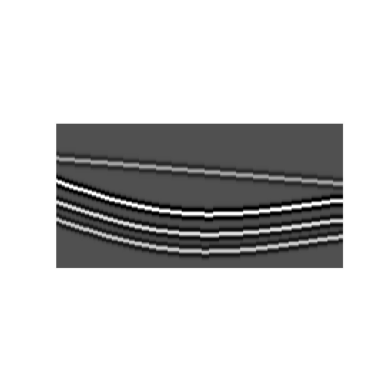

In [24]:
from PIL import Image
import matplotlib.pyplot as plt


# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes ticks and labels
plt.show()